In [46]:
import sys
sys.path.append("../parietal/hugo-richard-M2/functional_alignment/functional_alignment/")

%load_ext autoreload
%autoreload 2
from IPython.display import display, Javascript
disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""
display(Javascript(disable_js))
import numpy as np
from scipy.linalg import svd
from sklearn.decomposition import PCA
from sklearn.utils import check_random_state
from time import time
import matplotlib.pyplot as plt
from generator import create_orthogonal_matrix, generate_group_sparse_matrix, generate_random_orthogonal_matrix
from generator import generate_close_group_sparse_matrices
from generator import generate_fake_data
import numpy as np
from sklearn.decomposition import PCA
from time import time
import scipy.sparse as sp
from pca_srm import PCASRM
import scipy.stats as stats
import scipy
from sklearn.preprocessing import scale
from nilearn.input_data import NiftiMasker
import nibabel
from functional_alignment.deterministic_srm import DeterministicSRM
from functional_alignment.probabilistic_srm import ProbabilisticSRM
from functional_alignment.dictionary_srm import DictionarySRM
from functional_alignment.msdl_srm import MSDLSRM
from functional_alignment.graphnet_srm import GraphNetSRM
from functional_alignment.interpretable_srm import InterpretableSRM

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

# Generate Train and Test Data

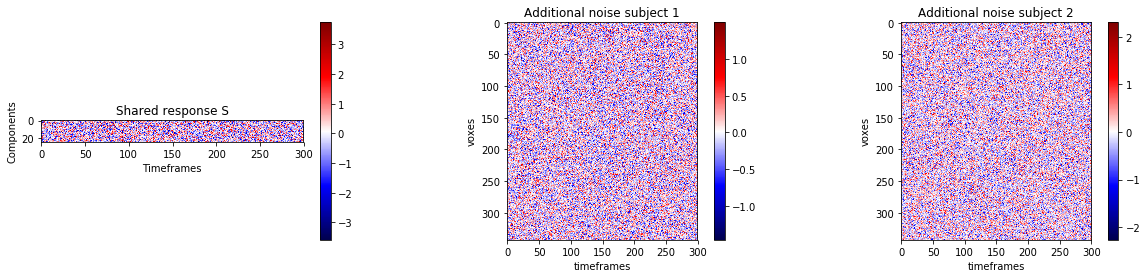

-------------------------------------------------------------------------------------
orthogonal


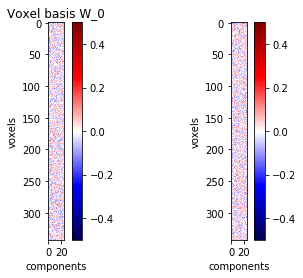

random


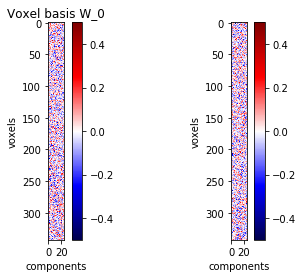

sparse


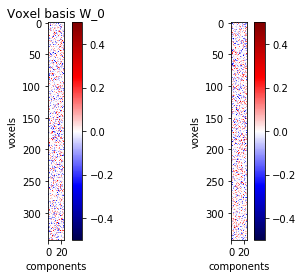

group_sparse


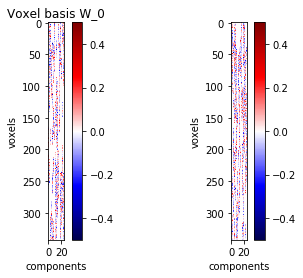

close_group_sparse


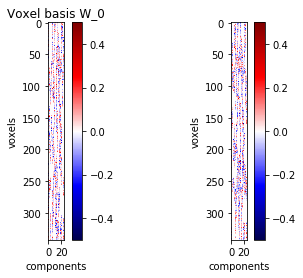

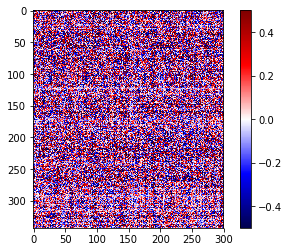

In [47]:
#n_samples is the number of subject
#n_component is the dimension of latent space


n_subjects = 20
n_components = 25
voxels = (7, 7, 7)
n_timeframes = 300

affine = np.eye(4)
shape = (voxels[0], voxels[1], voxels[2], n_timeframes)

masker = NiftiMasker(mask_img=nibabel.Nifti1Image(np.ones(shape[:3], dtype=np.int8), affine)).fit()

#parameters
noise_scale = np.random.normal(loc=0, scale=0.7, size=n_subjects)**2
isotropicLatentVariance = np.eye(n_components)
isotropicLatentVariance = isotropicLatentVariance.T.dot(isotropicLatentVariance)

data = generate_fake_data(n_subjects=n_subjects,
                          n_components=n_components,
                          n_voxels=np.array(voxels).prod(),
                          n_timeframes=n_timeframes,
                          noise_scale=noise_scale,
                          latent_variance=isotropicLatentVariance,
                         )

train_W = data["train_W"]
train_S = data["train_S"]
test_S = data["test_S"]
test_noise = data["test_noise"]
train_noise = data["train_noise"]

methods = ["orthogonal", "random", "sparse", "group_sparse", "close_group_sparse"]
plt.figure(figsize=(20, 4))
plt.subplot(131)
plt.title("Shared response S")
plt.imshow(data["train_S"], cmap="seismic")
plt.xlabel("Timeframes")
plt.ylabel("Components")
plt.colorbar()
plt.subplot(132)
plt.title("Additional noise subject 1")
plt.imshow(data["train_noise"][0], cmap="seismic")
plt.xlabel("timeframes")
plt.ylabel("voxes")
plt.colorbar()
plt.subplot(133)
plt.title("Additional noise subject 2")
plt.imshow(data["train_noise"][1], cmap="seismic")
plt.xlabel("timeframes")
plt.ylabel("voxes")
plt.colorbar()
plt.savefig('fig1')
plt.show()

# print("Shared response (S of size k, t)")
# plt.imshow(test_S)
# plt.colorbar()
# plt.show()
print("-------------------------------------------------------------------------------------")
for method in methods:
    print(method)
    plt.subplot(121)
    i = 0
    plt.title("Voxel basis W_%i"%(i))
    plt.imshow(data["train_W"][method][i], cmap="seismic", vmax=0.5, vmin=-0.5)
    plt.ylabel("voxels")
    plt.xlabel("components")
    plt.colorbar()
    plt.subplot(122)
    i=1
    plt.imshow(data["train_W"][method][i], cmap="seismic", vmax=0.5, vmin=-0.5)
    plt.ylabel("voxels")
    plt.xlabel("components")
    plt.colorbar()
    plt.savefig('fig2_%s'%method)
    plt.show()

plt.imshow(data["train_W"][method][i].dot(train_S), cmap="seismic", vmax=0.5, vmin=-0.5)
plt.colorbar()

# Training phase: optimization using different algorithms and data

In [58]:
def initialize_algorithms(methods, n_components):
    algorithms = []
    for method in methods:
        algos = []
        algos.append((DeterministicSRM(n_components=n_components, mask=masker),"Deterministic SRM"))
        algos.append((DictionarySRM(n_components=n_components, mask=masker, alpha=1.), "Dictionary Learning"))
        
        for grad_weight in [1., 10., 100.]:
            for l1_weight in [1., 10., 100.]:
                algos.append(
                    (InterpretableSRM(n_components=n_components, mask=masker, 
                     l1_weight=l1_weight, grad_weight=grad_weight), "ISRM_la%.1f_g%.1f"%(l1_weight, grad_weight)),
                )
        
        algorithms.append(algos)
    return algorithms
    

In [59]:
algorithms = initialize_algorithms(methods, n_components)
for i in range(len(algorithms[0])):
    print(algorithms[0][i][1])

Deterministic SRM
Dictionary Learning
ISRM_la1.0_g1.0
ISRM_la10.0_g1.0
ISRM_la100.0_g1.0
ISRM_la1.0_g10.0
ISRM_la10.0_g10.0
ISRM_la100.0_g10.0
ISRM_la1.0_g100.0
ISRM_la10.0_g100.0
ISRM_la100.0_g100.0


In [60]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = None

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout = self._original_stdout
    
def cov(A, B):
    AA = A / np.sqrt(np.sum(A ** 2, axis=1, keepdims=True))
    BB = B / np.sqrt(np.sum(B ** 2, axis=1, keepdims=True))
    return AA.dot(BB.T)

In [55]:
algorithms = initialize_algorithms(methods, n_components)
import sys

for i in range(len(methods)):
    method = methods[i]
    print(method)
    for j in range(len(algorithms[i])):
        algorithm, name = algorithms[i][j]
        train_X = [[
            masker.inverse_transform(
                (train_W[method][k].dot(train_S) + train_noise[k]).T
            )]
            for k in range(n_subjects)
        ]
        with HiddenPrints():
            algorithms[i][j] = algorithm.fit(train_X), name

orthogonal


/usr/local/lib/python3.6/site-packages/nilearn/input_data/masker_validation.py:74: UserWarning: Overriding provided-default estimator parameters with provided masker parameters :
Parameter mask_strategy :
    Masker parameter background - overriding estimator parameter epi

  warnings.warn(warn_str)


KeyboardInterrupt: 

## Training phase: fitting error

- We learn $\hat{W_k}$, $\hat{S_k}$ using $X_1, ..., X_n$

$E_k = ||X_k - \hat{W_k} \hat{S_k}||^2$

$E = \sum_k E_k$


orthogonal


/usr/local/lib/python3.6/site-packages/nilearn/input_data/masker_validation.py:74: UserWarning: Overriding provided-default estimator parameters with provided masker parameters :
Parameter mask_strategy :
    Masker parameter background - overriding estimator parameter epi

  warnings.warn(warn_str)


Deterministic SRM


<Figure size 2880x1440 with 0 Axes>

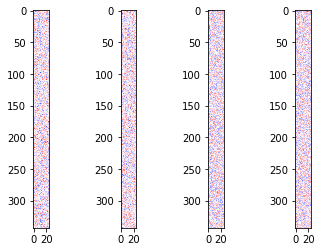

26.822564444448822
0.9999999999999999
1.0000000000000007
1.0000000000000009
0.9999999999999991
1.0000000000000004
0.9999999999999997
1.0
1.0000000000000004
0.9999999999999998
1.0000000000000004
1.0
0.9999999999999994
1.0000000000000004
1.0
1.0000000000000004
1.0000000000000002
1.0000000000000002
0.9999999999999998
0.9999999999999999
1.0000000000000004
1.0
0.9999999999999998
1.0000000000000004
0.9999999999999999
1.0
Dictionary Learning


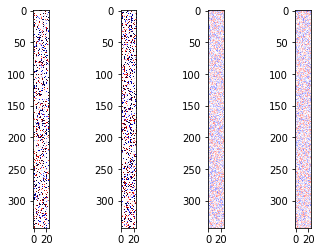

26.822564444448822
5.513113104989357
5.113672974081306
6.61704206485689
1.824057390099794
3.5602633149633967
8.707965969875428
4.034251399592468
5.7532816758125085
6.017208279537417
6.315531345108235
6.121403855438556
5.556317561975827
5.138264797691638
4.261967198793505
6.943015537784396
6.7070031328757915
7.826541912997947
4.518040794434207
4.959013260889454
4.710061900005274
7.813448562800459
7.043178431574205
2.7536485360576157
6.392961389371446
4.838666690883076
ISRM_la1.0_g1.0


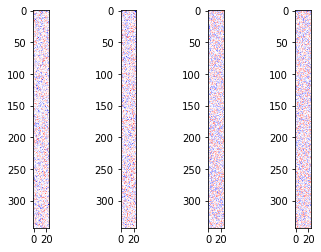

26.822564444448822
0.928463803139604
0.8700011675960474
0.900542755663969
0.9351326073738111
0.9145837444339643
0.9263808881959302
0.9098389829626682
0.9003042754365532
0.9333075375579803
0.8768141261967893
0.9295582402267888
0.9360845570377194
0.9396840083889302
0.9231343127883853
0.9420389487158387
0.9494125407741939
0.9294800081764012
0.9455845344514692
0.9272538481582161
0.9101801676868451
0.8856134627990347
0.9276082107245519
0.9197061047299783
0.8992880883049792
0.8997173363174884
ISRM_la10.0_g1.0


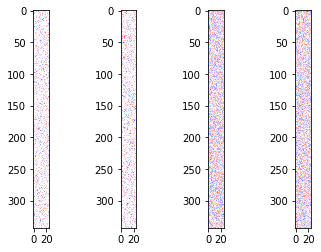

26.822564444448822
0.5871938102435433
0.5796200214738721
0.5671317683617921
0.566231397827116
0.593497793070458
0.6265997765880408
0.5239264713961863
0.5765712090997971
0.5543155217660649
0.5644232781428965
0.5868918242069479
0.5930549090803624
0.595119618725847
0.5846902101937911
0.6107260874335327
0.5416965188417443
0.5778029161901183
0.5506250896477466
0.5671985474895397
0.5788678308799861
0.6423492560741909
0.6450376030201926
0.5757019248166491
0.5812436290122743
0.5915986126670535
ISRM_la100.0_g1.0


26.822564444448822
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
ISRM_la1.0_g10.0


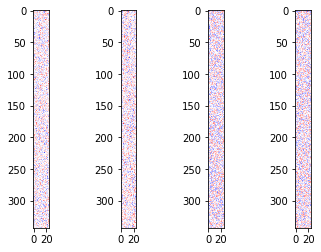

26.822564444448822
0.8312422188008116
0.8267263624013689
0.8274705490654342
0.7596221003051795
0.8096063125118813
0.7970040281913157
0.8323048741367594
0.8243221717825019
0.7847170350329331
0.840571749365869
0.8257966630891245
0.848700900224054
0.8286269240836539
0.8086090651603962
0.8007510576195149
0.8365646045822555
0.8149040076330847
0.81464790793878
0.7882240696755254
0.8296240232205957
0.801226839138792
0.8111184821599887
0.8004787711758817
0.8089792861450162
0.8277486067696582
ISRM_la10.0_g10.0


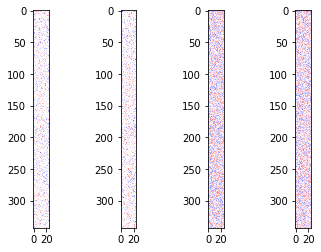

26.822564444448822
0.5365731546408532
0.5305091984772231
0.5208761939765295
0.5159046254138971
0.5447544101397701
0.5315927958854754
0.5059457367136161
0.4692451302348778
0.5131490558028361
0.5057557211160545
0.5501363187042531
0.5549876108201084
0.5252039582583402
0.5204431205774372
0.44254365521159617
0.5515302105365324
0.5021380592763655
0.5243176669024145
0.48777684939055405
0.5882208399273252
0.5564546144200389
0.45738074664223655
0.5506660727123996
0.4794294847837508
0.5571681591782187
ISRM_la100.0_g10.0


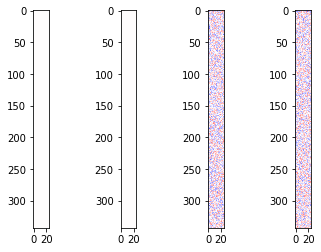

26.822564444448822
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
ISRM_la1.0_g100.0


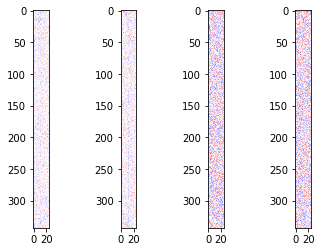

26.822564444448822
0.5412279102873688
0.4569020866384699
0.46607992499586265
0.44913276090955756
0.46946594039653416
0.47352473162469744
0.4208814586639007
0.3843312185535305
0.4752578508473706
0.44535368690719257
0.41439055206231873
0.5266930125960578
0.4069453360801077
0.44433675383954135
0.4988767886988102
0.44329824939375523
0.43049969457924375
0.4466178968038776
0.4624300190736215
0.4802078603554942
0.4389742173852169
0.3960823143406856
0.44151295470805124
0.4027070606430478
0.4052841488535231
ISRM_la10.0_g100.0


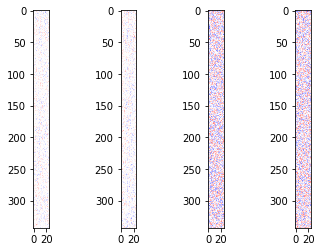

26.822564444448822
0.35251992390094206
0.37537128077815984
0.23775584331939809
0.26336917855672026
0.2988798659774344
0.3195231495690918
0.3016382733905222
0.2706490292712214
0.2802066696775231
0.25393036159475546
0.2731277881790635
0.31656511836929263
0.28493255210464974
0.31192756088148677
0.27132269774934287
0.2837327600854025
0.2794870541471541
0.2643592357434572
0.27847590217664386
0.2970835922628334
0.23103903312100632
0.23635071014077488
0.28471989975136963
0.27971489371542213
0.24055068444340383
ISRM_la100.0_g100.0


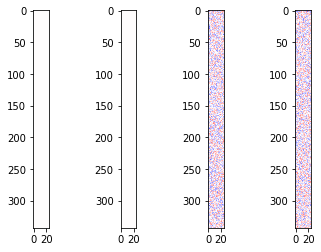

26.822564444448822
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [65]:
algorithms = initialize_algorithms(methods, n_components)
plt.figure(figsize=(15, 5))
for i in [0]:
    method = methods[i]
    print(method)
    errors = []
    algo_names = []
    for j in range(len(algorithms[i])):
        algorithm, name = algorithms[i][j]
        train_X = [[
            masker.inverse_transform(
                (train_W[method][k].dot(train_S) + train_noise[k]).T
            )]
            for k in range(n_subjects)
        ]
        
        with HiddenPrints():
            fit_S = algorithm.fit_transform(train_X)
        error = np.array([np.linalg.norm(masker.transform(train_X[k][0]).T - algorithm.inverse_transform(fit_S)[k])
                          - 
                          np.linalg.norm(masker.transform(train_X[k][0]).T - train_W[method][k].dot(train_S))
                          for k in range(n_subjects)]
                        ).mean()
        errors.append(error)
        algo_names.append(name)
        print(name)
        fig, axes = plt.subplots(1, 4)
        axes[0].imshow(algorithm.basis[0], cmap="seismic", vmax=0.5, vmin=-0.5)
        axes[1].imshow(algorithm.basis[1], cmap="seismic", vmax=0.5, vmin=-0.5)
        axes[2].imshow(train_W[method][0], cmap="seismic", vmax=0.5, vmin=-0.5)
        axes[3].imshow(train_W[method][1], cmap="seismic", vmax=0.5, vmin=-0.5)
        plt.show()
        print(np.array([np.linalg.norm(masker.transform(train_X[k][0]).T)
                          - 
                          np.linalg.norm(masker.transform(train_X[k][0]).T - train_W[method][k].dot(train_S))
                          for k in range(n_subjects)]
                        ).mean())
        for k in range(n_components):
            print(np.linalg.norm(algorithm.basis[0][:, k]))
    plt.plot(algo_names, errors, '-', label=method)
plt.legend()
plt.show()

- We learn $\hat{W_k}$ using $X_1, ..., X_n$
- We compute $\hat{S}$ using $\hat{W_k}$ and $X_1, ..., X_n$

$E_k = ||X_k - \hat{W_k} \hat{S_k}||^2$

$E = \sum_k E_k$

In [67]:
plt.figure(figsize=(25, 5))
for i in [0]:
    method = methods[i]
    print(method)
    errors = []
    algo_names = []
    for j in range(len(algorithms[i])):
        algorithm, name = algorithms[i][j]
        print(name)
        with HiddenPrints():
            masker = algorithm.masker
            train_X = [[
                masker.inverse_transform(
                    (train_W[method][k].dot(train_S) + train_noise[k]).T
                )]
                for k in range(n_subjects)
            ]
            fit_S = algorithm.transform(train_X)
            error = np.array([np.linalg.norm(masker.transform(train_X[k][0]).T - algorithm.inverse_transform(fit_S)[k])
                              - 
                              np.linalg.norm(masker.transform(train_X[k][0]).T - train_W[method][k].dot(train_S))
                              for k in range(n_subjects)]
                            ).mean()
            errors.append(error)
            algo_names.append(name)
    plt.plot(algo_names, errors, '-', label=method)
plt.legend()
plt.ylim(-10, 50)
plt.show()

orthogonal
Deterministic SRM
Dictionary Learning
ISRM_la1.0_g1.0
ISRM_la10.0_g1.0
ISRM_la100.0_g1.0
ISRM_la1.0_g10.0
ISRM_la10.0_g10.0
ISRM_la100.0_g10.0
ISRM_la1.0_g100.0
ISRM_la10.0_g100.0
ISRM_la100.0_g100.0


## Cosmoothing for training data

In [68]:
plt.figure(figsize=(25, 5))
for i in [0]:
    method = methods[i]
    print(method)
    with HiddenPrints():
        errors = []
        algo_names = []
        for j in range(len(algorithms[i])):
            algorithm, name = algorithms[i][j]
            masker = algorithm.masker
            train_X = [[
                masker.inverse_transform(
                    (train_W[method][k].dot(train_S) + train_noise[k]).T
                )]
                for k in range(n_subjects)
            ]
            error = []
            for s in range(n_subjects):
                index = np.delete(range(0, n_subjects), s)
                fit_S = algorithm.transform([train_X[ii] for ii in index],index=index)
                err = np.array([np.linalg.norm(masker.transform(train_X[s][0]).T - algorithm.inverse_transform(fit_S)[s])]).sum()
                error.append(err - np.linalg.norm(masker.transform(train_X[s][0]).T - train_W[method][s].dot(train_S)))
            errors.append(np.mean(error))
            algo_names.append(name)
        plt.plot(algo_names, errors, '-', label=method)
plt.legend()
plt.ylim(-10, 20)
plt.savefig('fig3')
plt.show()

orthogonal


## Cosmoothing for testing data
- Same Ws but different S and noise

orthogonal


/usr/local/lib/python3.6/site-packages/nilearn/input_data/masker_validation.py:74: UserWarning: Overriding provided-default estimator parameters with provided masker parameters :
Parameter mask_strategy :
    Masker parameter background - overriding estimator parameter epi

  warnings.warn(warn_str)


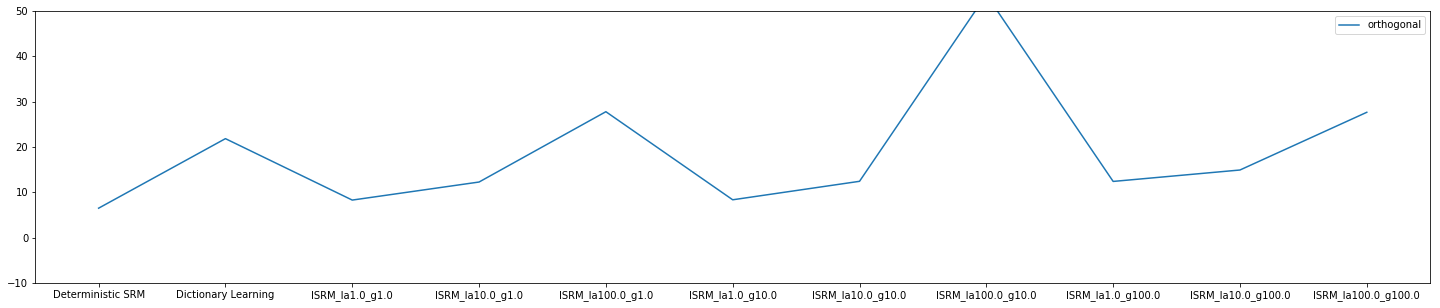

In [69]:
algorithms = initialize_algorithms(methods, n_components)
plt.figure(figsize=(25, 5))
for i in [0]:
    algorithm = algorithms[i][j]
    method = methods[i]
    errors = []
    algo_names = []
    print(method)
    for j in range(len(algorithms[i])):
        algorithm, name = algorithms[i][j]
        train_X = [[
            masker.inverse_transform(
                (train_W[method][k].dot(train_S) + train_noise[k]).T
            )]
            for k in range(n_subjects)
        ]
    
        test_X = [[
            masker.inverse_transform(
                (train_W[method][k].dot(test_S) + test_noise[k]).T
            )]
            for k in range(n_subjects)
        ]
        with HiddenPrints():
            algorithm.fit(train_X)
            error = []
            for s in range(n_subjects):
                index = np.delete(range(0, n_subjects), s)
                predicted_S = algorithm.transform([test_X[ii] for ii in index], index=index)
                err = np.linalg.norm(masker.transform(test_X[s][0]).T - algorithm.inverse_transform(predicted_S)[s])
                error.append(err - np.linalg.norm(masker.transform(test_X[s][0]).T - train_W[method][s].dot(test_S)))
            errors.append(np.mean(error))
            algo_names.append(name)
    plt.plot(algo_names, errors, '-', label=method)
plt.legend()
plt.ylim(-10, 50)
plt.savefig('fig5')
plt.show()


## Distance of each S_i from S_{-i} train time

In [ ]:
algorithms = initialize_algorithms(methods, n_components)
plt.figure(figsize=(25, 5))
for i in range(len(methods)):
    method = methods[i]
    print(method)
    errors = []
    algo_names = []
    for j in range(len(algorithms[i])):
        algorithm, name = algorithms[i][j]
        print(name)
        error = []
        train_X = [[
            masker.inverse_transform(
                (train_W[method][k].dot(train_S) + train_noise[k]).T
            )]
            for k in range(n_subjects)
        ]
        algorithm.fit(train_X)
        for s in range(n_subjects):
            index = np.delete(range(0, n_subjects), s)
            fit_S = algorithm.transform([train_X[ii] for ii in index],index=index)
            fit_S_i = algorithm.transform([train_X[s]],index=[s])
            
            err = np.linalg.norm(fit_S - fit_S_i) / np.linalg.norm(fit_S)
            error.append(err)
        algo_names.append(name)
        errors.append(np.mean(error))
    plt.plot(algo_names, errors, '-', label=method)
plt.legend()
plt.savefig('fig3')
plt.show()

## Distance of each W_iS from X_{i} train time

In [ ]:
algorithms = initialize_algorithms(methods, n_components)
plt.figure(figsize=(25, 5))
for i in range(len(methods)):
    method = methods[i]
    errors = []
    best_errors = []
    algo_names = []
    for j in range(len(algorithms[i])):
        algorithm, name = algorithms[i][j]
        train_X = [[
            masker.inverse_transform(
                (train_W[method][k].dot(train_S) + train_noise[k]).T
            )]
            for k in range(n_subjects)
        ]
        fit_S = algorithm.fit(train_X).transform(train_X)
        error = np.array([np.linalg.norm(masker.transform(train_X[k][0]).T - algorithm.inverse_transform(fit_S)[k])
                          for k in range(n_subjects)]
                        ).mean()
        best_error = np.array([np.linalg.norm(masker.transform(train_X[k][0]).T - train_W[method][k].dot(train_S))
                          for k in range(n_subjects)]
                        ).mean()
        errors.append(error)
        algo_names.append(name)
        best_errors.append(best_error)
    plt.plot(algo_names, errors, '-', label=method)
    plt.plot(algo_names, best_errors, '*', color="black")
plt.legend()
plt.show()